# 11.12.3 A specific case

In this notebook, we illustrate a Piecewise Deterministic Markov Process (PDMP) through the  simple example that is developped in section 11.12.3. We consider:
1. a simple numerical scheme that illustrates the PDMP on this example (to be posted soon);
2. a Monte-Carlo simulation of this same example (this second one enabling to compare results and computation times).


In [1]:
# IMPORT
%reset -f
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pdb
from scipy.interpolate import interp1d

In [2]:
# PARAMETERS
para = {}
# Theta <-> Scale
# Alpha <-> Shape
# Alpha = 1 <-> Weibull is equivalent to an exponential distribution with lambda=1/thpeta
para['scale'] = 365 #365, 1
para['shape'] = 10 #10, 0.5
para['agePrevMaint'] = np.inf # value of a that has to be optimized
para['downtime'] = 365
para['horizon'] = 365*10
para['delta'] = 1
nbHist = 5000

In [3]:
# $\lambda(t)$
t = 300
lt = para['shape']*(para['scale']**(-para['shape']))*(t**(para['shape']-1))
print('lt={:.5e}'.format(lt))

lt=4.68989e-03


<IPython.core.display.Javascript object>


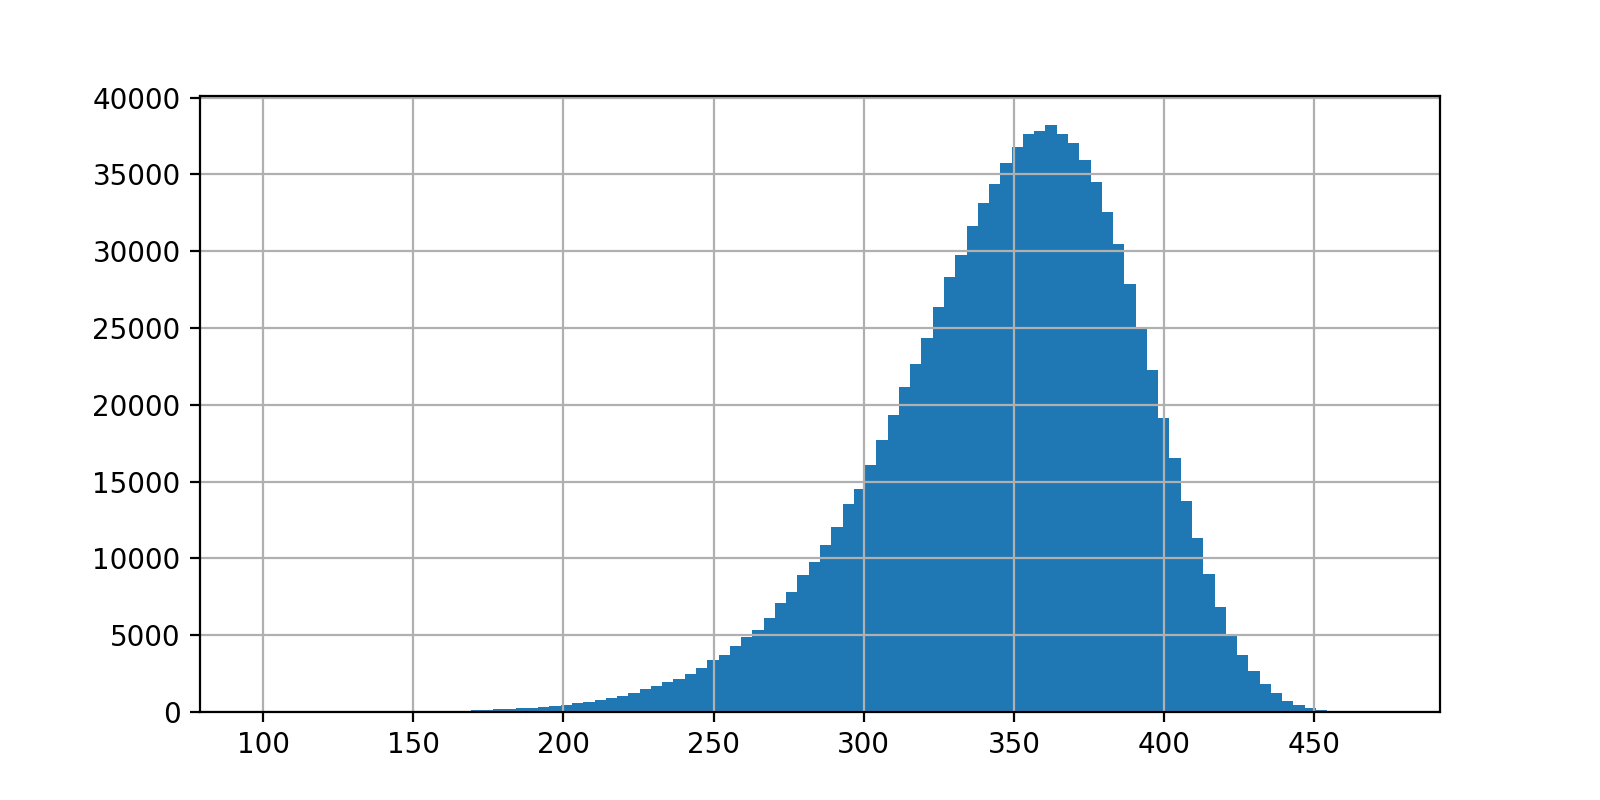

Median: 351.94
Mean:   347.31
Prc25:  322.34


In [4]:
x = para['scale']*np.random.weibull(para['shape'], int(1e6))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(x, 100)
ax.grid(True)

print('Median: {:.2f}'.format(np.median(x)))
print('Mean:   {:.2f}'.format(np.mean(x)))
print('Prc25:  {:.2f}'.format(np.quantile(x, 0.25)))

## Numerical Scheme - To be posted soon

## Monte Carlo simulation

In [7]:
def GetOneHistory(para):
    # Intial conditions
    currentState = 3
    currentTime = 0
    flagSim = True
    # Initial events time
    failComp1 = currentTime+para['scale']*np.random.weibull(para['shape']) 
    failComp2 = currentTime+para['scale']*np.random.weibull(para['shape'])
    prevMaint1 = currentTime+para['agePrevMaint']
    prevMaint2 = currentTime+para['agePrevMaint']
    corrMaint1 = np.inf
    corrMaint2 = np.inf
    # History initialization
    histoTime = np.append([], currentTime)
    histoState = np.append([], currentState)
    while flagSim:
        dT = np.min([failComp1, failComp2, prevMaint1, prevMaint2, corrMaint1, corrMaint2])
        currentTime = dT
        if (currentState==3):
            if (dT==failComp1):
                currentState = 2
                failComp1 = np.inf
                prevMaint1 = np.inf
                corrMaint1 = currentTime+para['downtime']
            elif (dT==failComp2):
                currentState = 1
                failComp2 = np.inf
                prevMaint2 = np.inf
                corrMaint2 = currentTime+para['downtime']
            elif (dT==prevMaint1):
                failComp1 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint1 = currentTime+para['agePrevMaint']
            elif (dT==prevMaint2):
                failComp2 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint2 = currentTime+para['agePrevMaint']
            else:
                raise ValueError('Inconsistent event')
        elif (currentState==2):
            if (dT==failComp2):
                currentState = 0
                failComp2 = np.inf
                prevMaint2 = np.inf
                corrMaint2 = currentTime+para['downtime']
            elif (dT==prevMaint2):
                failComp2 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint2 = currentTime+para['agePrevMaint']
            elif (dT==corrMaint1):
                currentState = 3
                failComp1 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint1 = currentTime+para['agePrevMaint']
                corrMaint1 = np.inf
            else:
                raise ValueError('Inconsistent event')
        elif (currentState==1):
            if (dT==failComp1):
                currentState = 0
                failComp1 = np.inf
                prevMaint1 = np.inf
                corrMaint1 = currentTime+para['downtime']
            elif (dT==prevMaint1):
                failComp1 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint1 = currentTime+para['agePrevMaint']
            elif (dT==corrMaint2):
                currentState = 3
                failComp2 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint2 = currentTime+para['agePrevMaint']
                corrMaint2 = np.inf
            else:
                raise ValueError('Inconsistent event')
        elif (currentState==0):
            if (dT==corrMaint1):
                currentState = 1
                failComp1 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint1 = currentTime+para['agePrevMaint']
                corrMaint1 = np.inf
            elif (dT==corrMaint2):
                currentState = 2
                failComp2 = currentTime+para['scale']*np.random.weibull(para['shape'])
                prevMaint2 = currentTime+para['agePrevMaint']
                corrMaint2 = np.inf
            else:
                raise ValueError('Inconsistent event')
        else:
            raise ValueError('Unknown state')
        # Update variables
        histoTime = np.append(histoTime, currentTime)
        histoState = np.append(histoState, currentState)
        if currentTime>=para['horizon']:
            flagSim = False
    return (histoTime, histoState)

<IPython.core.display.Javascript object>


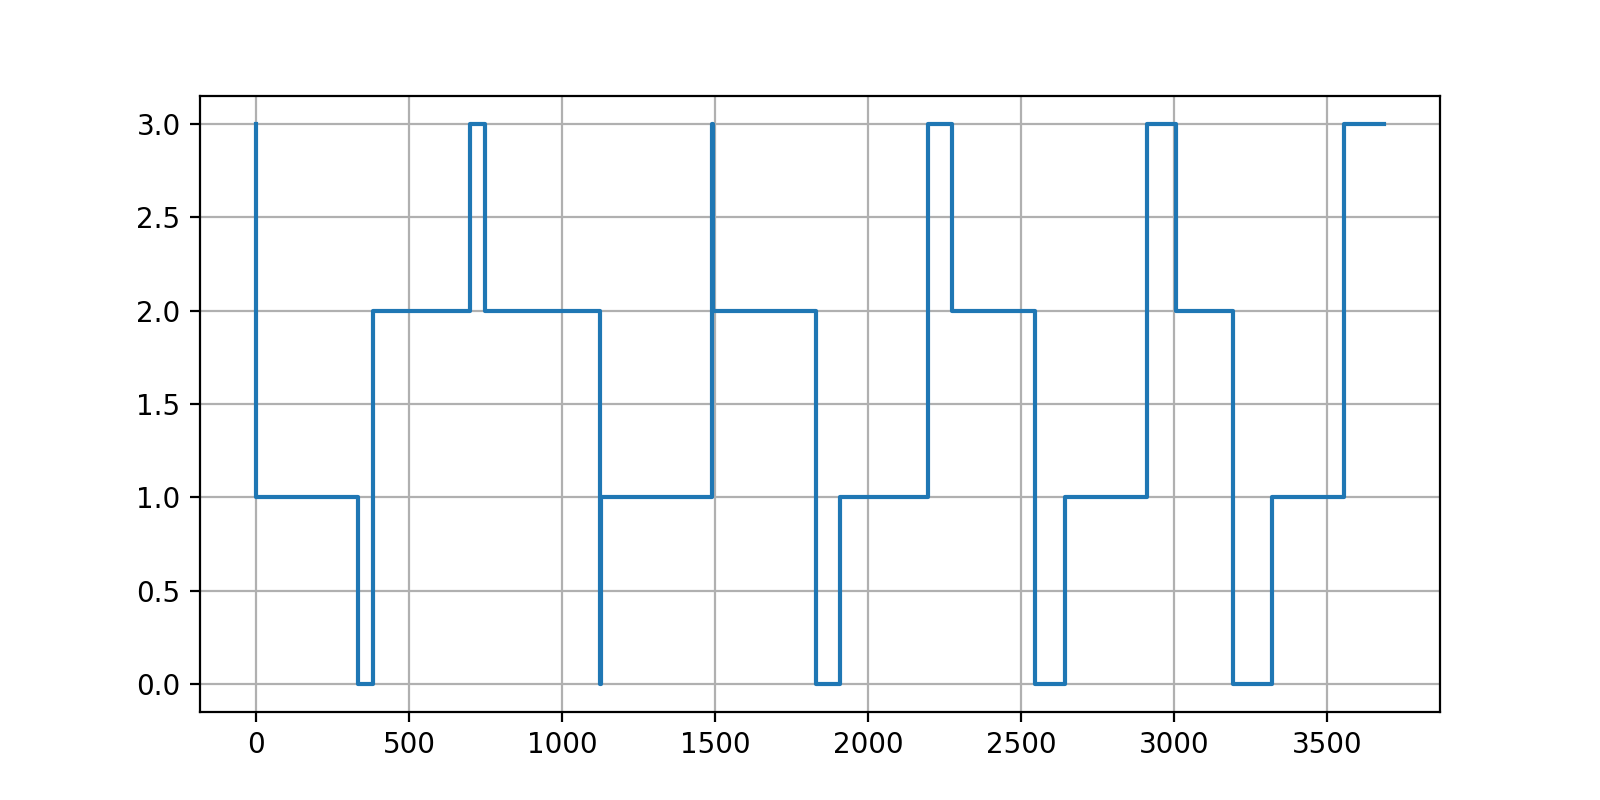

[3. 1. 0. 2. 3. 2. 0. 1. 3. 2. 0. 1. 3. 2. 0. 1. 3. 2. 0. 1. 3.]
[   0.          332.0114347   381.14030806  697.0114347   746.14030806
 1123.07214738 1127.64358878 1488.07214738 1492.64358878 1830.43358042
 1907.37646039 2195.43358042 2272.37646039 2546.09738675 2641.14095349
 2911.09738675 3006.14095349 3190.08417566 3318.91954379 3555.08417566
 3683.91954379]


In [8]:
if True:
    (histoTime, histoState) = GetOneHistory(para)
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.step(histoTime, histoState)
    ax.grid(True)
    print(histoState)
    print(histoTime)

In [9]:
def GetHistories(nbN, para):
    '''Simulate several histories and get transitions and associated times
    '''
    simHistoTime = []
    simHistoState = []
    # Main loop
    for id in range(nbN):
        (histoTimeTmp, histoStateTmp) = GetOneHistory(para)
        simHistoTime.append(histoTimeTmp)
        simHistoState.append(histoStateTmp)
    return (simHistoTime, simHistoState)

In [10]:
(simTime, simState) = GetHistories(nbHist, para)

In [11]:
vTimeCal = np.linspace(0, para['horizon'], 10000)
mProbSim = np.zeros((4, vTimeCal.shape[0]))
for kd in range(nbHist):
    fTmp = interp1d(simTime[kd], simState[kd], kind='previous')
    vY = fTmp(vTimeCal)
    for jd in range(4):
        mProbSim[jd, :] = mProbSim[jd, :]+(vY==jd)
mProbSim = mProbSim/nbHist

<IPython.core.display.Javascript object>


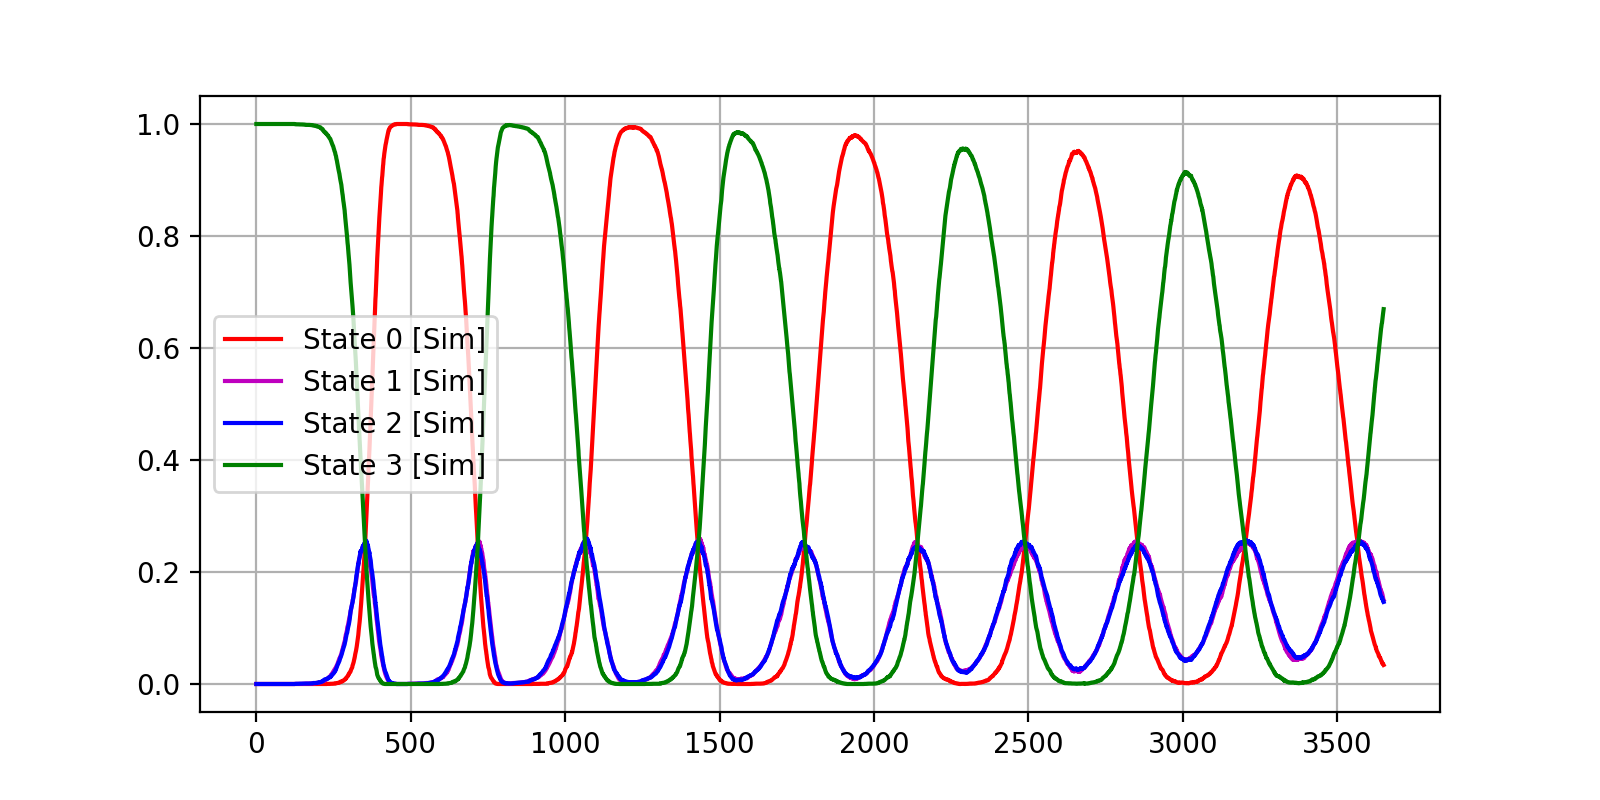

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
vColor = ['r', 'm', 'b', 'g']
for jd in range(4):
    ax.plot(vTimeCal, mProbSim[jd, :],
            color=vColor[jd], label='State {:d} [Sim]'.format(jd))
ax.grid(True)
ax.legend()
